## Reconstruction parcimonieuse


On s'intéresse au problème

$$\hspace{5cm} (\mathcal{P})\quad \min_{x\in \mathbb{R}^n}f(x) = \frac{1}{2}\Vert H x-y \Vert_W^2+\lambda \Vert x \Vert_1 $$

avec $y\in \mathbb{R}^m$ une observation du signal à reconstruire, $H\in \mathcal{M}_{m,n}(\mathbb{R})$, $W\in \mathcal{M}_{m}(\mathbb{R})$ symétrique définie positive. La matrice $W$ introduit une pondération sur les composantes du résidu.

**Question 1 :** Justifier la convexité de la fonctionnelle et donner un sous-gradient.


$g = H^TW(Hx-y)+\lambda sign(x) \in \partial f(x)$

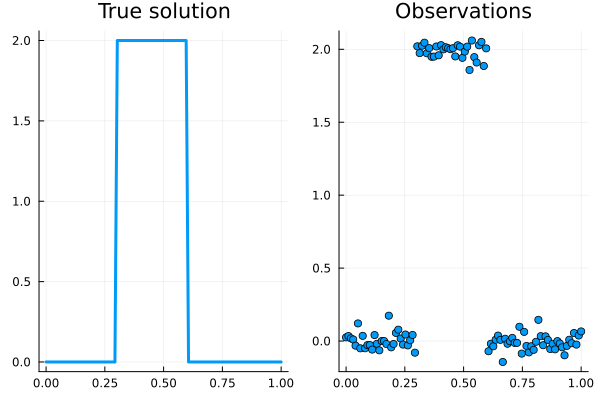

In [1]:
#Pkg.add("Plots")
using Plots
using LinearAlgebra

# Construction du problème #
############################

# solution à reconstruire 
##########################
dx=0.01;

n=Int(1/dx);#+1;
px=LinRange(0.,1.,n);
xt=zeros(n,1);

for i = 1:n
    if (px[i] > 0.3 && px[i]< 0.6)
        xt[i] = 2;         
    end
end


#observations
#############
nobs=1;
m=Int(floor(n/nobs));
var_obs=0.05;
sigmaW=ones(m,1)+2.0*rand(Float64,(m,1));

H=zeros(m,n);
py=zeros(m,1);
W=zeros(m,m);
for i=1:m
   H[i,(i-1)*nobs+1]=1;
   py[i]=px[(i-1)*nobs+1]; 
   W[i,i]=sigmaW[i];
end    
y=H*xt+var_obs*randn(Float64,(m,1));


p1=plot(px,xt,title="True solution",label=["xt"],lw=3);
p2=scatter(py,y,title="Observations",lw=3);
plot(p1,p2,layout=(1,2),legend=false)

**Question 2 :** Proposer le calcul de l'évaluation de f et d'un sous-gradient de f

In [2]:
# Fonction évaluant f en x
function evalf(x,y,H,W,lambda) 
    # Insérer votre code
    return 0.5 * ((H*x-y)'*W*(H*x-y))[1] + lambda * sum(abs.(x))
    # Fin insérer code
end

# Fonction évaluant un sous-gradient de f en x
function subgradf(x,y,H,W,lambda) 
    # Insérer votre code
    return H'*W*(H*x-y) + lambda*sign.(x)
    # Fin insérer code
end

subgradf (generic function with 1 method)

**Question 3 :** Résoudre le problème en utilisant un algorithme de sous-gradient. Vous implanterez les trois stratégies de pas vues en cours. Vous afficherez les courbes de convergence de $f_{best}^k$. 

**Question 4 :** Quelle influence a le paramètre $\lambda$ sur la convergence de l'algorithme et la qualité de la soltuion optimisée ?

Plus $\lambda$ est grand moins l'algorithme va converger

In [3]:
#Pkg.add("Plots")
using Plots

#Initialisation
x = zeros(n,1);
xbest=x;
i = 0;
fbest =1000000; # $f_{best}^0$
histo =[];# Suite des itérés f_{best}^k

lambda=1e-2;

pas=1e-2;
itermax=500;

xp=x;
while i < itermax
    i = i + 1
    # Insérer votre code
    g = subgradf(xp, y, H, W, lambda)
    if pas == 1
        alpha = 1e-2;
    elseif pas == 2
        alpha = 1 / (1*i)
    else
        alpha = 10 / (i*norm(g))
    end
    xp = xp - alpha * g
    fp = evalf(xp, y, H, W, lambda)
    if fp < fbest
        fbest = fp
        xbest = xp
    end
    # Fin insérer code
    
    # Stockage
    append!( histo, fbest)
end
#histo
#Affichage des courbes de convergence
plotly();
iter=1:itermax;
plot(iter,histo,title="Convergence curve",label=["f"],lw=3)

[ Info: For saving to png with the Plotly backend PlotlyBase and PlotlyKaleido need to be installed.


In [4]:
x=[xt,xbest];

plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

**Question 5 :** On pose $h(x)=\lambda \Vert x\Vert_1$ et $g(x)=\frac{1}{2}\Vert Hx-y\Vert_W^2$. Donner une expression analytique de la fonction proximale de h et implanter cette fonction. Implanter la fonction $g$ ainsi que son gradient.  
$h(x) = \lambda \|x\|_1$  
$\underset{\forall j \in [1,n]}{[prox~h(x)]_j} = \left\{
    \begin{array}{ll}
        x_j-\lambda ~ si ~ x_j > \lambda \\
         0 ~ si ~ x_j \in [-\lambda,\lambda]\\
         x_j + \lambda ~ si ~ x_j < -\lambda
    \end{array}
\right.$

In [5]:
# Evaluation de prox_h
function proxh(x,lambda) 
# Insérer votre code
    to_return = zeros(size(x))
    for j in eachindex(x)
        if x[j] > lambda
            to_return[j] = x[j] - lambda
        elseif x[j] < - lambda
            to_return[j] = x[j] + lambda
        else
            to_return[j] = 0
        end
    end
    return to_return
# Fin insérer code
end

#Evaluation de g
function evalg(x,y,H,W)
# Insérer votre code
   return 0.5 * ((H*x-y)'*W*(H*x-y))[1]
# Fin insérer code
end    


#Evaluation du gradient de g
function gradg(x,y,H,W)
# Insérer votre code
   return H'*W*(H*x-y)
# Fin insérer code
end    

gradg (generic function with 1 method)

**Question 6 :** Résoudre le problème par la méthode du gradient proximal avec recherche linéaire pour le pas. Vous implanterez en prémabule la fonction de recherche linéaire.

In [6]:
# Fonction calculant le pas par recherche linéaire
# Insérer votre code
function recherche_lineaire(alphap, lambda, beta, xp, y, H, W)
    alpha_l = alphap
    condition = true
    while condition
        alpha_l = beta * alpha_l
        
        G = (1/alpha_l) * (xp-proxh(xp-alpha_l*gradg(xp,y,H,W), alpha_l*lambda)) 
        gauche = evalg(proxh(xp-alpha_l*gradg(xp,y,H,W), alpha_l*lambda),y,H,W)
        droite = evalg(xp,y,H,W) - (alpha_l*gradg(xp,y,H,W)'*G)[1] + (alpha_l/2)*norm(G)^2
        condition = gauche > droite
    end
    return alpha_l
end
# Fin insérer code

recherche_lineaire (generic function with 1 method)

In [7]:
#Initialisation
x = zeros(n,1);
xbest=x;
i = 0;
fbest =1000000; # $f_{best}^0$
histo =[];# Suite des itérés f_{best}^k 

lambda0=1e-2;
itermax=500;
beta=0.5;

xp=x;

while i < itermax
    i = i + 1;
    # Insérer votre code
    alphap = recherche_lineaire(5, lambda0, beta, xp, y, H, W)
    G = (1/alphap) * (xp-proxh(xp-alphap*gradg(xp,y,H,W), alphap*lambda0))
    xp = xp - alphap * G
    
    fp = evalf(xp, y, H, W, lambda0)
    if fp < fbest
        fbest = fp
        xbest = xp
    end
    # Fin insérer code
    
    # Stockage
    append!( histo, fbest)
end
#histo
#Affichage des courbes de convergence
plotly();
iter=1:itermax;
plot(iter,histo,title="Convergence curve",label=["f"],lw=3)

In [17]:
x=[xt,xbest];
print(px, "\n\n")
print(size(x[1]))
plot(px,x,title="Reconstruction",label=["True solution" "Optimized solution"],lw=3)

LinRange{Float64}(0.0, 1.0, 100)

(100, 1)

**Question 7 :** Evaluez la sensisibilité de l'algorithme aux différents paramètres : $\lambda_0$, $\beta$, itermax.  

In [78]:
function sensi(total, ligne, lambda0=1e-2, beta=0.5, itermax=500)
    #Initialisation
    x = zeros(n,1);
    xbest=x;
    i = 0;
    fbest =1000000; # $f_{best}^0$
    histo =[];# Suite des itérés f_{best}^k 

    xp=x;

    while i < itermax
        i = i + 1;
        # Insérer votre code
        alphap = recherche_lineaire(5, lambda0, beta, xp, y, H, W)
        G = (1/alphap) * (xp-proxh(xp-alphap*gradg(xp,y,H,W), alphap*lambda0))
        xp = xp - alphap * G

        fp = evalf(xp, y, H, W, lambda0)
        if fp < fbest
            fbest = fp
            xbest = xp
        end
        # Fin insérer code

        # Stockage
        append!( histo, fbest)
    end
    #histo
    #Affichage des courbes de convergence
    iter=1:itermax;
    x=[xt,xbest];
    subplot(total, 2, ligne)
    PyPlot.plot(iter,histo)
    title("Convergence curve")
    legend(["f"])
    subplot(total, 2, ligne+1)
    PyPlot.plot(px,xt)
    PyPlot.plot(px, xbest)
    title("Reconstruction")
    legend(["True solution", "Optimized solution"])
    subplots_adjust(hspace=0.3, top=2*total/3)
    show()
end

sensi (generic function with 6 methods)

lambda0 = 1.0e-5   beta = 1.0e-10   itermax = 20.0
-----
lambda0 = 1.0e-5   beta = 1.0e-10   itermax = 100.0
-----
lambda0 = 1.0e-5   beta = 1.0e-10   itermax = 500.0
-----
lambda0 = 1.0e-5   beta = 1.0e-10   itermax = 1000.0
-----
lambda0 = 1.0e-5   beta = 1.0e-5   itermax = 20.0
-----
lambda0 = 1.0e-5   beta = 1.0e-5   itermax = 100.0
-----
lambda0 = 1.0e-5   beta = 1.0e-5   itermax = 500.0
-----
lambda0 = 1.0e-5   beta = 1.0e-5   itermax = 1000.0
-----
lambda0 = 1.0e-5   beta = 0.1   itermax = 20.0
-----
lambda0 = 1.0e-5   beta = 0.1   itermax = 100.0
-----
lambda0 = 1.0e-5   beta = 0.1   itermax = 500.0
-----
lambda0 = 1.0e-5   beta = 0.1   itermax = 1000.0
-----
lambda0 = 1.0e-5   beta = 0.5   itermax = 20.0
-----
lambda0 = 1.0e-5   beta = 0.5   itermax = 100.0
-----
lambda0 = 1.0e-5   beta = 0.5   itermax = 500.0
-----
lambda0 = 1.0e-5   beta = 0.5   itermax = 1000.0
-----
lambda0 = 1.0e-5   beta = 0.75   itermax = 20.0
-----
lambda0 = 1.0e-5   beta = 0.75   itermax = 100.0
-----

lambda0 = 100.0   beta = 0.1   itermax = 500.0
-----
lambda0 = 100.0   beta = 0.1   itermax = 1000.0
-----
lambda0 = 100.0   beta = 0.5   itermax = 20.0
-----
lambda0 = 100.0   beta = 0.5   itermax = 100.0
-----
lambda0 = 100.0   beta = 0.5   itermax = 500.0
-----
lambda0 = 100.0   beta = 0.5   itermax = 1000.0
-----
lambda0 = 100.0   beta = 0.75   itermax = 20.0
-----
lambda0 = 100.0   beta = 0.75   itermax = 100.0
-----
lambda0 = 100.0   beta = 0.75   itermax = 500.0
-----
lambda0 = 100.0   beta = 0.75   itermax = 1000.0
-----
lambda0 = 100.0   beta = 0.99   itermax = 20.0
-----
lambda0 = 100.0   beta = 0.99   itermax = 100.0
-----
lambda0 = 100.0   beta = 0.99   itermax = 500.0
-----
lambda0 = 100.0   beta = 0.99   itermax = 1000.0
-----
lambda0 = 1000.0   beta = 1.0e-10   itermax = 20.0
-----
lambda0 = 1000.0   beta = 1.0e-10   itermax = 100.0
-----
lambda0 = 1000.0   beta = 1.0e-10   itermax = 500.0
-----
lambda0 = 1000.0   beta = 1.0e-10   itermax = 1000.0
-----
lambda0 = 1000.0 

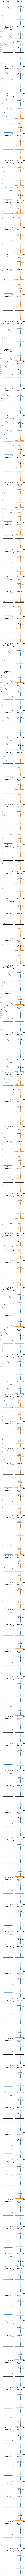

In [79]:
using PyPlot
liste_lambda0 = [1e-5,1e-2,1e-1,0,1,10,100,1000]
liste_beta = [1e-10, 1e-5, 0.1, 0.5, 0.75, 1-1e-2]
liste_itermax = [20, 100, 500, 1e3]
ligne = 1
total = size(liste_lambda0)[1] * size(liste_beta)[1] * size(liste_itermax)[1]
for l in liste_lambda0
    for b in liste_beta
        for i in liste_itermax
            print("lambda0 = ", l, "   beta = ", b, "   itermax = ", i)
            sensi(total, ligne, l, b, i)
            print("\n-----\n")
            ligne = ligne + 2
        end
    end
end

In [80]:
print(total)

192